In [13]:
@time using Plots
@time using Images

  0.000267 seconds (316 allocations: 16.766 KiB)
  0.000279 seconds (246 allocations: 13.234 KiB)


## Auxilliary subroutines for SIR simulation

In [276]:
function neighbourIndices(nType::Int64, rad::Int64)
    indices = []
    if(nType == 0)
        indices = vcat([[i, 0] for i in -rad:rad], [[0, j] for j in -rad:rad])
    elseif(nType == 1)
        indices = [[i, j] for i in -rad:rad for j in -rad:rad]
    elseif(nType == 2)
        indices = [[i, j] for j in -rad:rad for i in (abs(j) - rad):(rad - abs(j))]
    end
    
    indices = [CartesianIndex(ind...) for ind in setdiff(indices, [[0,0]])]
end


neighbourIndices (generic function with 3 methods)

In [279]:
function SIRSmodel(n::Int64, tauI::Int64, tauR::Int64, nType::Int64, rad::Int64, nsteps::Int64, anim::Bool, init)
    grid = zeros(Int64, (n, n)) #2D grid
    nData = zeros(Int64, (nsteps, 3)) #S,I,R count
    frames = [] #to store grid for display
    
    infp = 0 #infection probability
    tau0 = tauR + tauI #complete disease cycle 
    relNeighbour = neighbourIndices(nType, rad) #relative index of neighbours
    isInfected(x) = 1 <= x <= tauI #infected check
    indices = [CartesianIndex(i,j) for i in (rad+1):(n-rad) for j in (rad+1):(n-rad)]

    #initial conditions
    grid[n÷2, n÷2]= 1
    
    #boundary conditions; fixed
    grid[1:rad, :] .= tauI + 1
    grid[(n-rad+1):n, :] .= tauI + 1
    grid[:, 1:rad] .= tauI + 1
    grid[:, (n-rad+1):n] .= tauI + 1   
    
    prev = copy(grid) #copy of the grid
    push!(frames, copy(grid))
    
    #initial count
    nData[1, 1] = count(x -> x==0, grid)
    nData[1, 2] = count(x -> x==1, grid)
    nData[1, 3] = count(x -> x==2, grid)
    
    for k in 2:nsteps
        nData[k, :] = nData[k-1, :]
        
        for index in indices
            if(prev[index] == 0) #susceptible
                infp = count(isInfected.(prev[relNeighbour .|> x-> index+x]))/length(relNeighbour)
                
                if(rand()<infp) #infection
                    grid[index] += 1
                    nData[k, 1] -= 1
                    nData[k, 2] += 1
                end
                
            elseif(prev[index] < tau0) #infected/refractory
                grid[index] += 1
                
                if(grid[index] == tauI + 1) #transition to R
                    nData[k, 2] -= 1
                    nData[k, 3] += 1
                end
            
            elseif(prev[index] == tau0) #transition to S
                grid[index] = 0
                nData[k, 3] -= 1
                nData[k, 1] += 1
            end
        end
        
        prev = copy(grid)
        push!(frames, copy(grid))
    end
    
    if(anim)
        
        #colormap
        colors = vcat([RGB{N0f8}(0, 0, 0)], range(RGB{N0f8}(0.5,0.0,0.0), stop=RGB{N0f8}(0.862,0,0), length= tauI),range(RGB{N0f8}(1,0.458,0.0), stop=RGB{N0f8}(1, 1, 0.196), length=tauR))
        cmap = Dict(zip(0:tau0+1, colors))
        
        animGIF = @animate for i = 1:nsteps 
            plot([cmap[p] for p in frames[i]])
        end
        
        gif(animGIF, "anim_fps15.gif", fps = 15)
    end
    
    return nData
end     
    

SIRSmodel (generic function with 3 methods)

 13.476072 seconds (22.46 M allocations: 949.872 MiB, 1.54% gc time)
  0.210821 seconds (98.21 k allocations: 5.063 MiB)


┌ Info: Saved animation to 
│   fn = /home/akshay/code-repo/ComplexSystems/anim_fps15.gif
└ @ Plots /home/akshay/.julia/packages/Plots/uCh2y/src/animation.jl:104


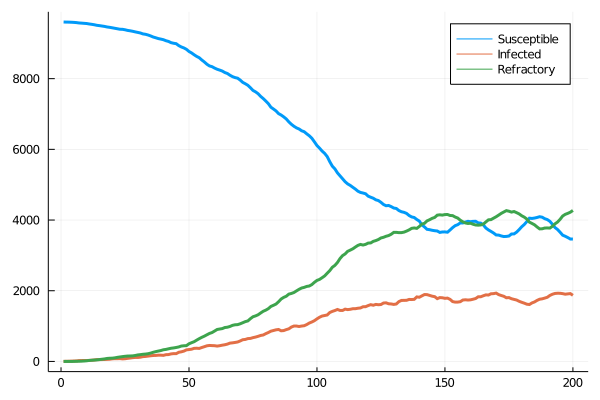

In [281]:
#function SIRSmodel(n, tauI, tauR, nType, rad, nsteps anim, init)
nsteps = 200
@time data = SIRSmodel(100, 4, 9, 0, 1, nsteps, true, 0)
x = 1:nsteps
@time plot(x, data, label = ["Susceptible" "Infected" "Refractory"], lw = 3, grid = true)